In [1]:
%reset -f
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import DBFunctions as db
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
#cnx = sqlite3.connect('Prognosedaten.db')

#df = db.GetLoad().join(db.GetRenewables()).join(db.GetLoad()).join(db.GetIDPrices())
df = db.GetNRVSaldo().join(db.GetLoad()).join(db.GetIDPrices()).join(db.GetDAPrices()).join(db.GetRenewables()).join(db.GetSRL())



num_folds = 4

acc_per_fold = []
loss_per_fold = []

In [3]:
df["PV_Error"] = df["PV_Ante"] - df["PV_Post"]
df["WI_Error"] = df["WI_Ante"] - df["WI_Post"]
df=df.drop(['PV_Ante','PV_Post','WI_Ante','WI_Post'], axis=1)
df=df.drop(['VorgehMenge_Neg','VorgehMenge_Pos','Leistungspreis_Pos','Leistungspreis_Neg'], axis=1)
df=df.rename(columns={"Arbeitspreis_Pos": "SRL_Arbeitspreis_Pos", "Arbeitspreis_Neg": "SRL_Arbeitspreis_Neg", "AbgerMenge_Pos": "SRL_AbgerMenge_Pos", "AbgerMenge_Neg": "SRL_AbgerMenge_Neg"})
df = df.dropna()

In [4]:


print(df.shape)
#print(df.dropna())

(130923, 12)


In [5]:
pdY = df[['SRL_AbgerMenge_Pos', 'SRL_AbgerMenge_Neg', 'SRL_Arbeitspreis_Pos','SRL_Arbeitspreis_Neg']].copy()
pdX = df.drop(['SRL_AbgerMenge_Pos', 'SRL_AbgerMenge_Neg', 'SRL_Arbeitspreis_Pos','SRL_Arbeitspreis_Neg'], axis=1)


#pdX_train=(pdX_train-pdX_train.min())/(pdX_train.max()-pdX_train.min())
#pdX_test=(pdX_test-pdX_test.min())/(pdX_test.max()-pdX_test.min())

X = pdX.to_numpy()
Y = pdY.to_numpy()

X = np.asarray(X).astype(np.float32)
Y = np.asarray(Y).astype(np.float32)

#X=(X-X.min())/(X.max()-X.min())

#print(train.shape)
#print(pdX_test.columns)
#print(pdX_test)
#print("Data poccessed starting on the ML stuff")
#print(Xtest[:, [2]])
#plt.plot(Xtest[:, [2]],color='blue',linewidth=0.1)
#plt.show()
print(X)
print(X[:,0])


[[0.12668024 0.6107517  0.12861055 ... 0.19844276 0.12836587 0.12148397]
 [0.12991923 0.6113909  0.12852392 ... 0.19844276 0.12836587 0.12190762]
 [0.12976426 0.6088341  0.12850848 ... 0.19844276 0.12836587 0.12302672]
 ...
 [0.12472858 0.6194941  0.12866533 ... 0.3254249  0.12836587 0.07320277]
 [0.12453748 0.6124235  0.12859826 ... 0.3254249  0.12836587 0.0733512 ]
 [0.12463105 0.6077425  0.12857789 ... 0.3254249  0.12836587 0.0747892 ]]
[0.12668024 0.12991923 0.12976426 ... 0.12472858 0.12453748 0.12463105]


In [6]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

#Define the callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [7]:
# K-fold Cross Validation model evaluation
fold_no = 1
cvscores = []
for train, test in kfold.split(X, Y):

	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(90, activation='relu', input_shape=[X.shape[1]]))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(tf.keras.layers.Dense(4))
	
	sgd = tf.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
	rmspop = tf.keras.optimizers.RMSprop(0.001)#chills at 2.3
	model.compile(optimizer=rmspop,loss='mean_squared_error')
	
	
	# Generate a print
	print('------------------------------------------------------------------------')
	print(f'Training for fold {fold_no} ...')
  
	# Fit data to model
	history = model.fit(X[train], Y[train],
              #batch_size=batch_size,
              epochs=5)
              #verbose=verbosity)

	# evaluate the model
	scores = model.evaluate(X[test], Y[test], verbose=0)
	#print(model.metrics_names[0])
	#print(scores)
	print("%s: %.2f" % (model.metrics_names[0], scores))
	cvscores.append(scores)

	# Increase fold number
	fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
3069/3069 [==============================] - 12s 4ms/step - loss: 1712.3409
Epoch 2/5
3069/3069 [==============================] - 13s 4ms/step - loss: 1702.1639
Epoch 3/5
3069/3069 [==============================] - 13s 4ms/step - loss: 1459.2677
Epoch 4/5
3069/3069 [==============================] - 13s 4ms/step - loss: 1153.7645
Epoch 5/5
3069/3069 [==============================] - 14s 5ms/step - loss: 1075.4091
loss: 1058.21
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
3069/3069 [==============================] - 14s 4ms/step - loss: 1680.1421
Epoch 2/5
3069/3069 [==============================] - 11s 4ms/step - loss: 1669.8442
Epoch 3/5
3069/3069 [==============================] - 9s 3ms/step - loss: 1374.3958
Epoch 4/5
3069/3069 [==============================] - 8s 3ms/step - loss: 1094.1825
Epoch 5/5
3069/3069 

In [8]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Average scores for all folds:
1339.28 (+/- 850.17)
------------------------------------------------------------------------


84.48158


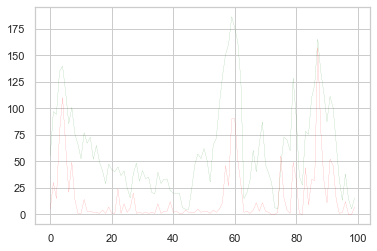

43.746822


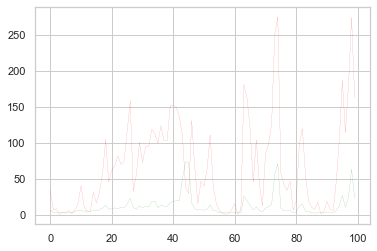

28.878983


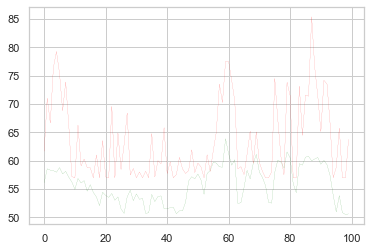

22.90005


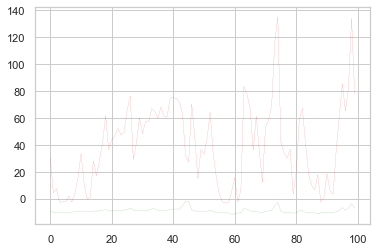

In [9]:
predictions = model.predict(X)
sns.set(style="whitegrid",palette=sns.color_palette("Paired",9))
#truth = Y_MRL_Arbeitspreis_Pos >= predictions
#for i in range(truth.shape[0]):
#    if (truth[0][i]):
#        predictions[i] = Y_MRL_Arbeitspreis_Pos[i]
for i in range(4):
    print(np.sqrt(mean_squared_error(Y[:,i],predictions[:,i])))
    plt.plot(predictions[:100,i],color='green',linewidth=0.1)
    plt.plot(Y[:100,i],color='red',linewidth=0.1)
    plt.show()





In [10]:
data = np.array([[1, 2], [3,4], [5,6], [7,8]])
print(data)


# Creating pandas dataframe from numpy array
dataset = pd.DataFrame({'Column1': data[:, 0],'Column2': data[:, 1]})
print(dataset)
dataset.Column1 *=5.44
print(dataset)

#print(dataset.sample(frac=0.8,random_state=200))

#normed_matrix = normalize(et, axis=0, norm='l1')

#df.sample(frac=0.8,random_state=200)


[[1 2]
 [3 4]
 [5 6]
 [7 8]]
   Column1  Column2
0        1        2
1        3        4
2        5        6
3        7        8
   Column1  Column2
0     5.44        2
1    16.32        4
2    27.20        6
3    38.08        8


In [11]:
df1 = pd.DataFrame(np.random.randint(0,5,size=(4, 4)), columns=list('ABCD'))
df2 = pd.DataFrame(np.random.randint(0,5,size=(4, 4)), columns=list('ABCD'))

for i in range(0,4):
    df1['A'][i] = i;
    df2['A'][i] = i;


print(df1)
print(df2)


df1.reset_index('A', drop=False).join(df2.rename_axis('a1').set_index('a2', append=True)

print(df1)

SyntaxError: invalid syntax (<ipython-input-11-c4735f7a05cd>, line 15)